# Data Challenge ANCAP
Federica Bouvier, Sofia Borrazas, María del Pilar Nogues & Guillermo Robatto.

## Desafio
Lograr una estimación de la variable DQO en la Cámara de Aforo PTE a partir de los datos que se miden en forma continua, de forma de poder tomar acciones correctivas más rápidamente en caso de que se estimara que la variable no se encuentra en rango aceptable, sin tener que esperar a contar con los resultados de los análisis químicos correspondientes. Un efluente con alta DQO puede tener efectos perjudiciales significativos en la calidad del agua y en la salud de los ecosistemas acuáticos, de allí el interés en mejorar el control de dicha variable para mantenerla en rango aceptable.


### Registros disponibles

#### a)      Archivo con Datos continuos de la cámara de aforo

Se cuenta con registros conteniendo datos determinados automáticamente a intervalos de un minuto. Se dispone de más de cuatro años de registros automáticos continuos aproximadamente.

#### b)      Datos diarios cámara aforo PTE (Planta de Tratamiento de Efluentes):

Se cuenta con registros de los análisis de la muestra diaria (normalmente de lunes a viernes). Se dispone aproximadamente de 1700 datos de resultados de ensayo con determinación de DQO.


### Algunos conceptos clave:

#### Conductividad

La conductividad es la capacidad que posee una solución acuosa de conducir la corriente eléctrica, dicha habilidad depende de la concentración total de iones, de la movilidad y valencia de los mismos, así como también de la temperatura a la que se realiza la medida.

 
#### DQO (Demanda Química de Oxígeno)

La Demanda Química de Oxígeno (DQO) es la medida de oxígeno equivalente a la materia orgánica que es susceptible a ser oxidada por un oxidante químico específico fuerte, en condiciones específicas de temperatura y tiempo. La cantidad de oxidante consumido se expresa en términos de su equivalencia de oxígeno. Los componentes tanto orgánicos como inorgánicos de la muestra son pasibles de oxidación, pero en la mayoría de los casos predominan los componentes orgánicos y son de mayor interés.


#### Sólidos Suspendidos

El término Sólidos Suspendidos se aplica a la parte de los sólidos totales retenida por un filtro de fibra de vidrio.

El término Sólidos Suspendidos Totales se aplica a los residuos de material que quedan en un filtro después de la evaporación en estufa a 103 - 105 °C.

Los Sólidos Suspendidos Fijos corresponden a los residuos remanentes del incinerado a 550 °C y los Sólidos Suspendidos Volátiles corresponden a los compuestos perdidos durante la calcinación a 550 °C (que dan una aproximación de la cantidad de materia orgánica presente en la muestra).


#### Turbidez

La turbidez en el agua es causada por material en suspensión o coloidal provenientes de arcillas, materiales orgánicos e inorgánicos finamente divididos, plancton y otros organismos microscópicos. Es una expresión de la propiedad óptica que causa disminución en la transmisión de la luz a través de la muestra. Se mide en unidades de turbidez nefelométrica (NTU).

### ¿Cómo se evaluarán las soluciones?

Las soluciones (notebooks) que se presenten serán evaluadas considerando:

- el Root-Mean-Squared-Error (RMSE) entre el valor real de la variable medida en laboratorio y el valor predicho entregado para cada una de las variables del desafío.

- la cantidad de predicciones que se encuentre en el rango del valor real correspondiente a esa predicción  +- 10%.

In [174]:
# !pip install missingno

In [175]:
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

In [176]:
# lo corri de kaggle pero si lo hacen de sus compus pongan aca el archivo relativo del repo lol asi ya queda
data_lab = pd.read_csv('/kaggle/input/data-ancap2/Ensayos_Laboratorio_Camara_ Aforo_PTE(in).csv', encoding='latin1', sep = ';')
estimacion_dqo = pd.read_csv('/kaggle/input/data-ancap2/Estimacion_DQO_Camara_ Aforo_PTE(in).csv', sep = ';')

In [177]:
data_lab.head()

,Fecha,Hora,Temperatura (ºC),pH,Turbiedad (NTU),DQO \n(mg O2/L)
0,07/10/2021,8:50,33.0,7.65,17.40,162
1,08/10/2021,9:00,30.9,7.72,8.23,143
2,11/10/2021,8:30,31.7,7.50,13.19,135
3,12/10/2021,9:00,32.9,7.50,5.37,91
4,13/10/2021,9:30,32.8,7.70,3.52,96


Dataframes generados:
- Data lab -> Información de los ensayos de laboratorio en la camara de aforo
- Data camara -> Información de la camara de aforo   #### ES EL QUE FALTA IMPORTAR
- Estimacion DQO -> Dataset test de predicciones

In [178]:
estimacion_dqo.head()

,Fecha,Hora,DQO \n(mg O2/L)
0,16/04/2024,8:50,NaN
1,17/04/2024,8:50,NaN
2,18/04/2024,9:20,NaN
3,19/04/2024,9:00,NaN
4,22/04/2024,9:00,NaN


# EDA 
(arranco solo del data lab pq el otro dataset no lo importe, desp es solo ir agregandolo en cada cat)

In [179]:
data_lab.describe()

,Temperatura (ºC),pH,Turbiedad (NTU)
count,581.000000,580.000000,576.000000
mean,28.649570,7.294897,7.221007
std,3.781013,0.498734,5.370371
min,19.000000,6.020000,1.100000
25%,26.100000,7.000000,3.830000
50%,29.000000,7.290000,5.755000
75%,31.500000,7.620000,9.002500
max,36.000000,11.340000,44.100000


In [180]:
data_lab.dtypes

Fecha                object
Hora                 object
Temperatura (ºC)    float64
pH                  float64
Turbiedad (NTU)     float64
DQO \n(mg O2/L)      object
dtype: object

In [181]:
# La target esta contaminada de un string, lo reemplace con 50 pero tenemos que ver que funcione mejor
data_lab['DQO \n(mg O2/L)'] = data_lab['DQO \n(mg O2/L)'].replace('<100', 50)
data_lab['DQO \n(mg O2/L)'] = pd.to_numeric(data_lab['DQO \n(mg O2/L)'], errors='coerce')

# Fecha y hora estan en formato incorrecto + nueva col completa
data_lab = data_lab.dropna(subset=['Fecha', 'Hora'])
data_lab['Fecha'] = pd.to_datetime(data_lab['Fecha'], format='%d/%m/%Y', errors='coerce')
data_lab['Hora'] = data_lab['Hora'].astype(str).str.replace('.', ':', regex=False)

data_lab['Fecha_Hora'] = pd.to_datetime(
    data_lab['Fecha'].astype(str) + ' ' + data_lab['Hora'].astype(str),
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)

# ver el resultado de la transformacion
print(data_lab[['Fecha', 'Hora', 'Fecha_Hora']].head())



       Fecha  Hora          Fecha_Hora
0 2021-10-07  8:50 2021-10-07 08:50:00
1 2021-10-08  9:00 2021-10-08 09:00:00
2 2021-10-11  8:30 2021-10-11 08:30:00
3 2021-10-12  9:00 2021-10-12 09:00:00
4 2021-10-13  9:30 2021-10-13 09:30:00


## Missing values

<Axes: >

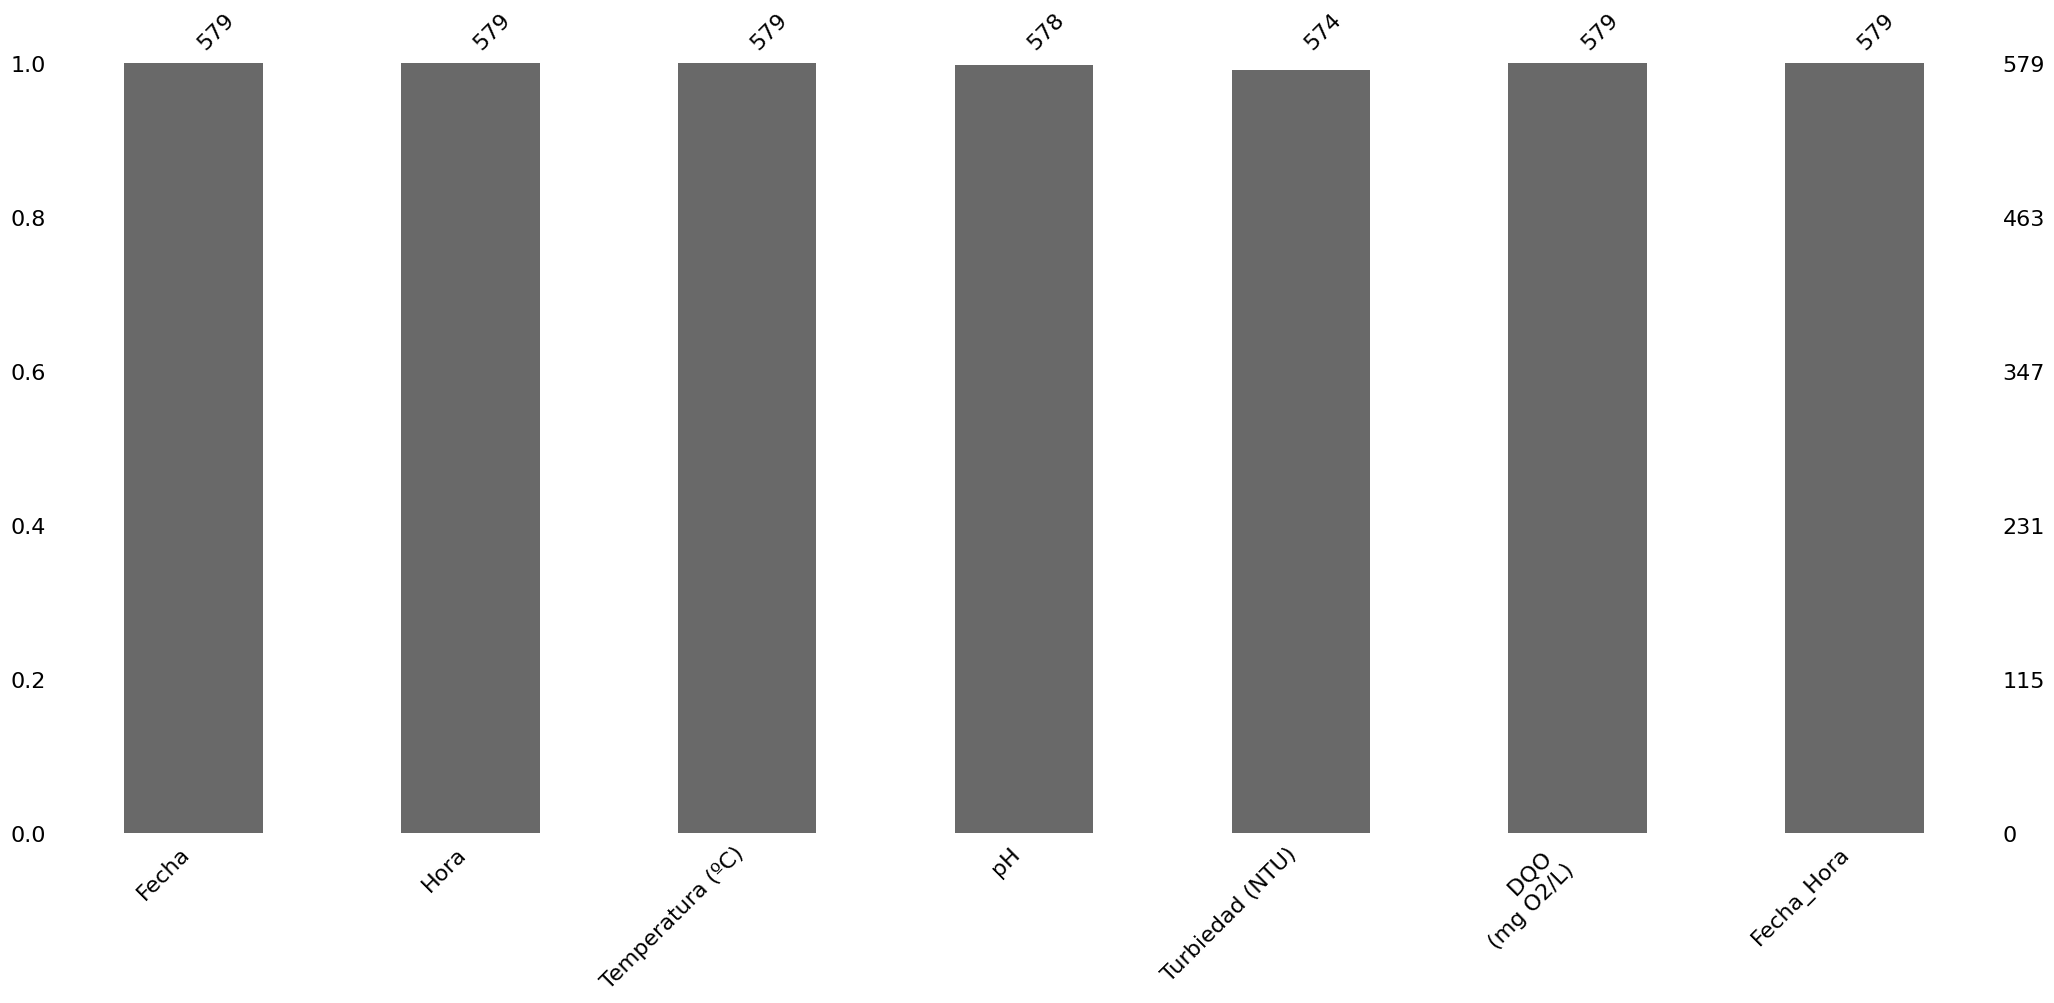

In [182]:
msno.bar(data_lab)

<Axes: >

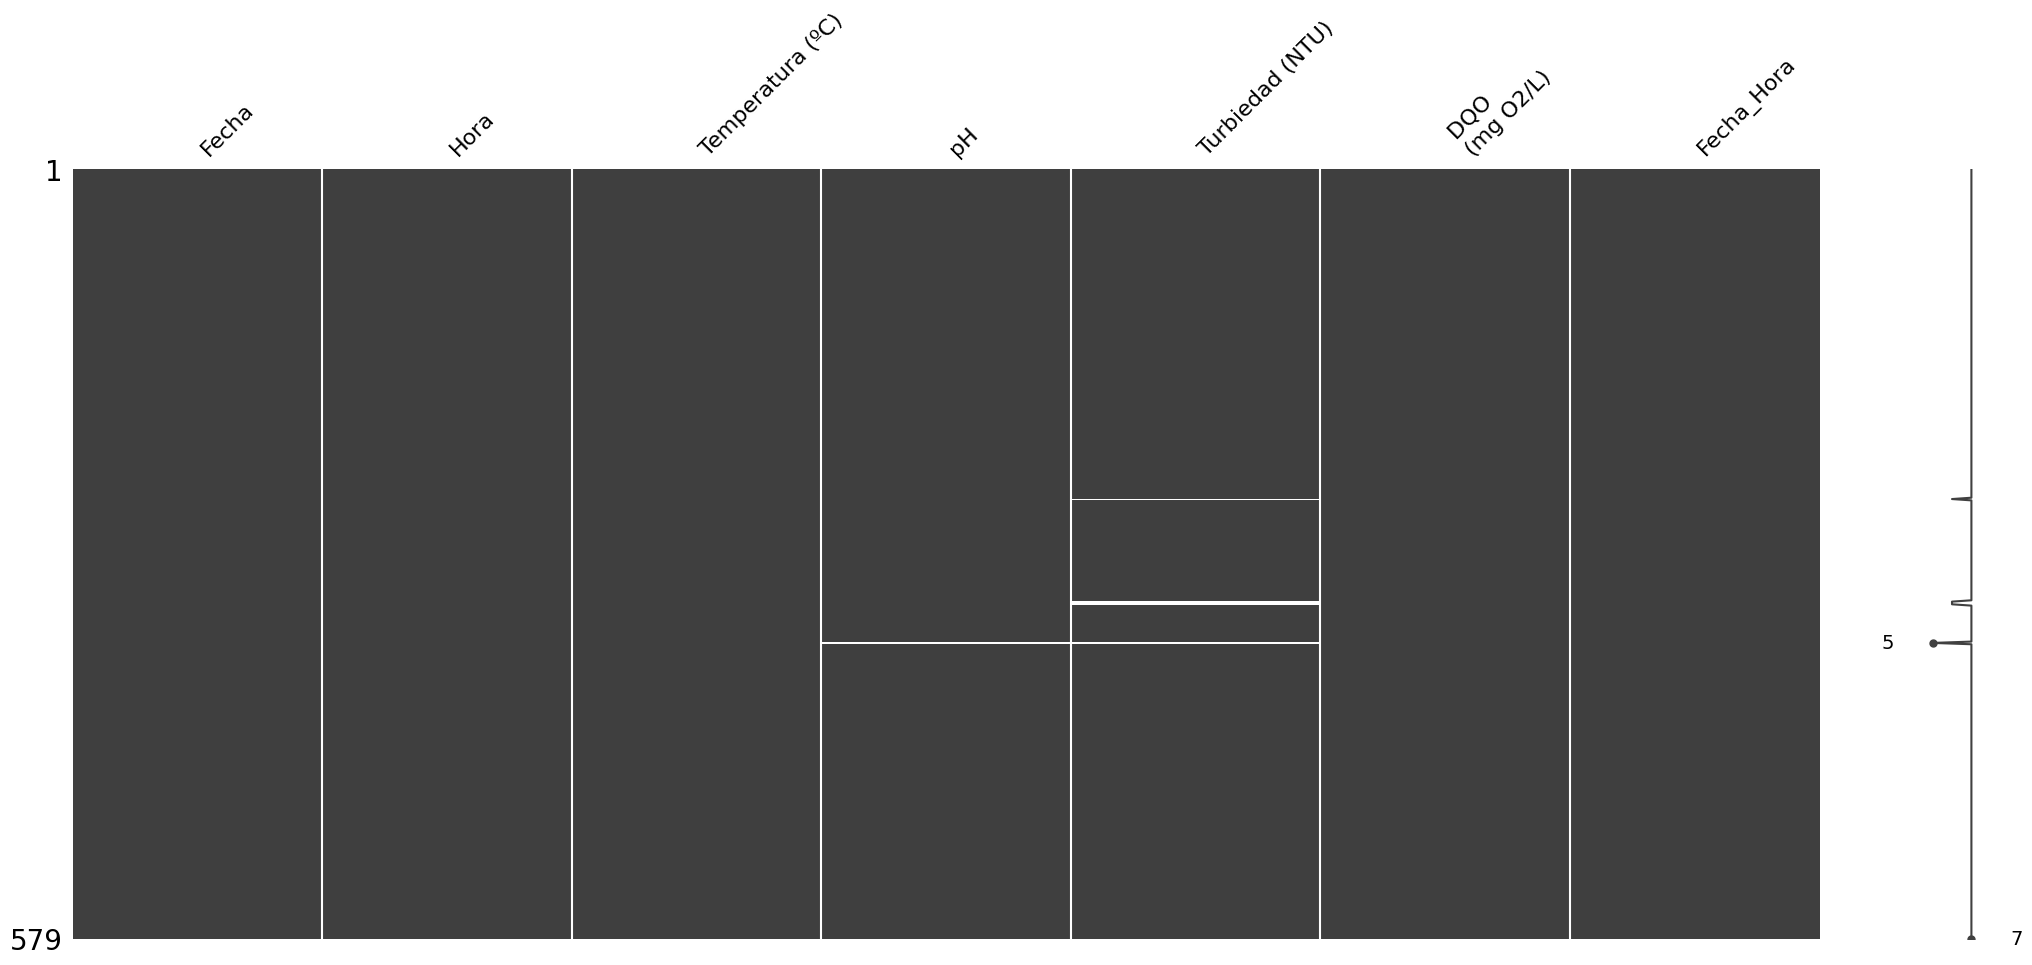

In [183]:
msno.matrix(data_lab)

## Distribuciones

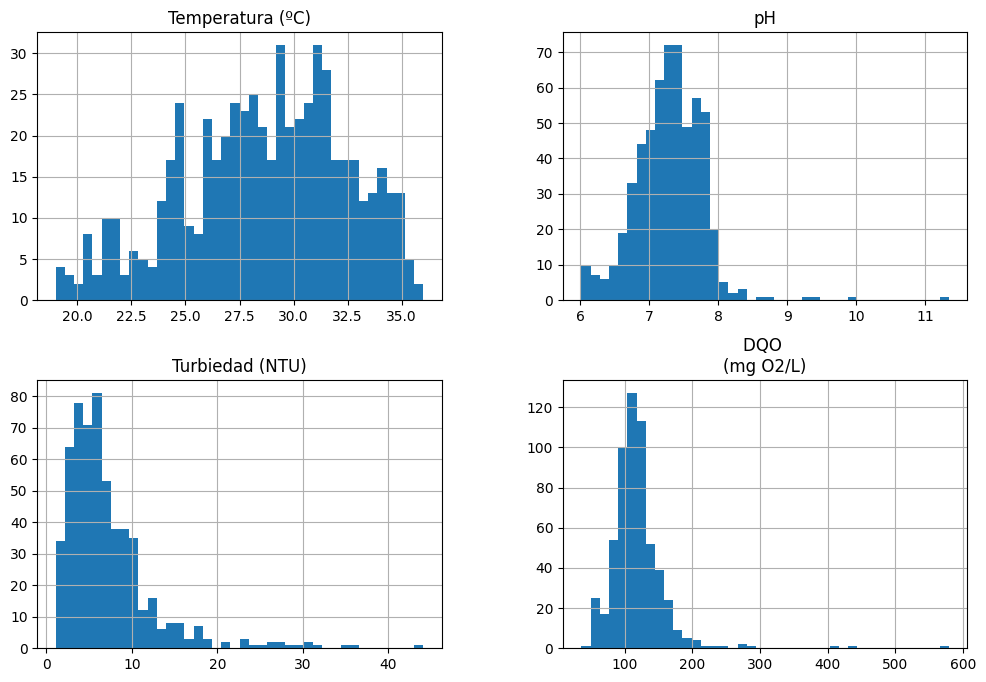

In [184]:
data_lab[['Temperatura (ºC)', 'pH', 'Turbiedad (NTU)', 'DQO \n(mg O2/L)']].hist(bins=40, figsize=(12, 8))
plt.show()

## Relaciones en el tiempo

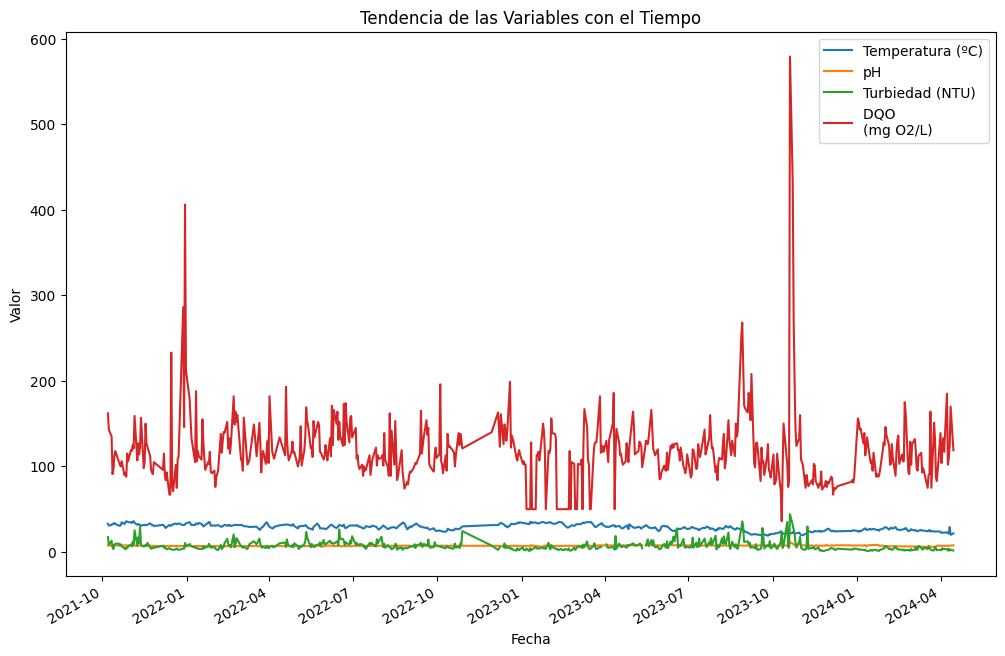

In [185]:
data_lab.set_index('Fecha')[['Temperatura (ºC)', 'pH', 'Turbiedad (NTU)', 'DQO \n(mg O2/L)']].plot(figsize=(12, 8))
plt.title('Tendencia de las Variables con el Tiempo')
plt.ylabel('Valor')
plt.show()


In [186]:
data_lab.head()

,Fecha,Hora,Temperatura (ºC),pH,Turbiedad (NTU),DQO \n(mg O2/L),Fecha_Hora
0,2021-10-07,8:50,33.0,7.65,17.40,162,2021-10-07 08:50:00
1,2021-10-08,9:00,30.9,7.72,8.23,143,2021-10-08 09:00:00
2,2021-10-11,8:30,31.7,7.50,13.19,135,2021-10-11 08:30:00
3,2021-10-12,9:00,32.9,7.50,5.37,91,2021-10-12 09:00:00
4,2021-10-13,9:30,32.8,7.70,3.52,96,2021-10-13 09:30:00


In [187]:
# funcion para nada tomada prestada de otro proyecto mio lol

def plot_categorical_numerical(df, categorical_col, numerical_col, summary_ = False):
    # Calcular la media de la columna numérica por cada categoría
    summary = df.groupby(categorical_col)[numerical_col].mean().reset_index()

    plt.figure(figsize=(12, 6))

    sns.barplot(x=categorical_col, y=numerical_col, data=df, palette= 'Blues')
    media_numerica = df[numerical_col].mean()
    plt.axhline(y=media_numerica, color='red', linestyle='--', label='Media')

    plt.xlabel(categorical_col)
    plt.ylabel(f'Media de {numerical_col}')
    plt.title(f'Relación entre {categorical_col} y {numerical_col}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    if summary_ == True:
        return summary

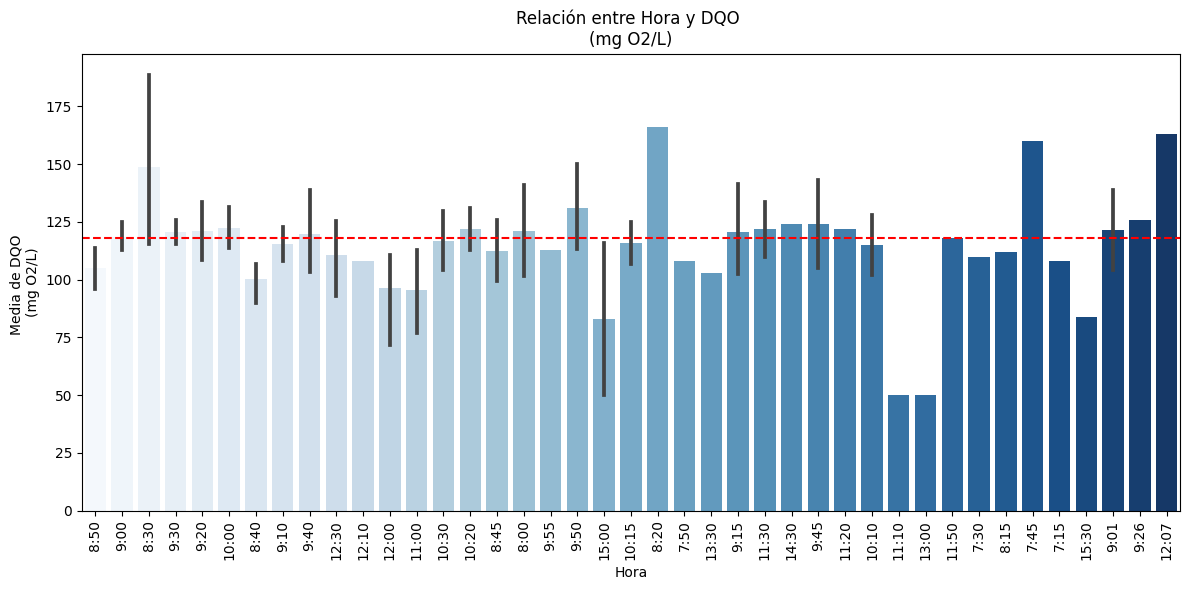

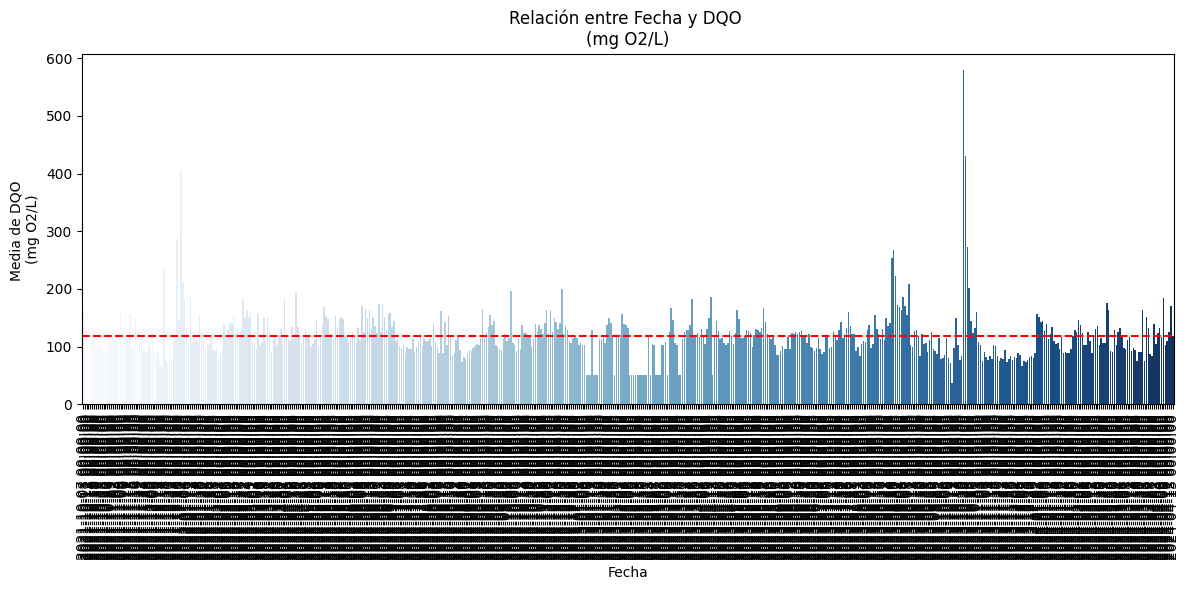

In [190]:
plot_categorical_numerical(data_lab, 'Hora', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'Fecha', 'DQO \n(mg O2/L)')

No se ve un carajo de fecha asique hago mini tratamiento

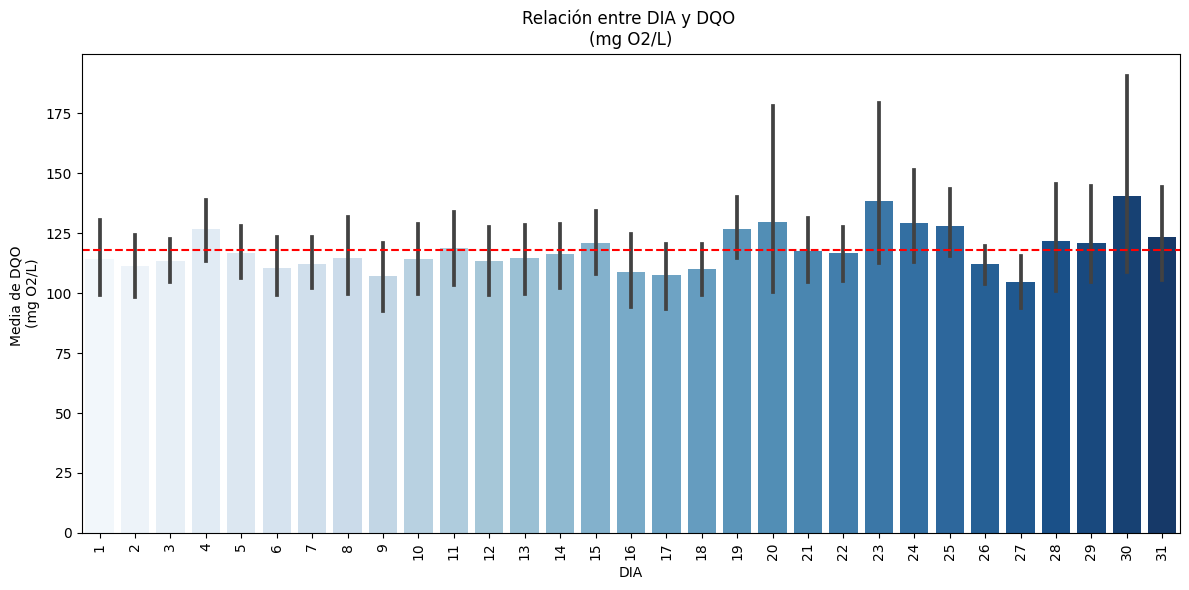

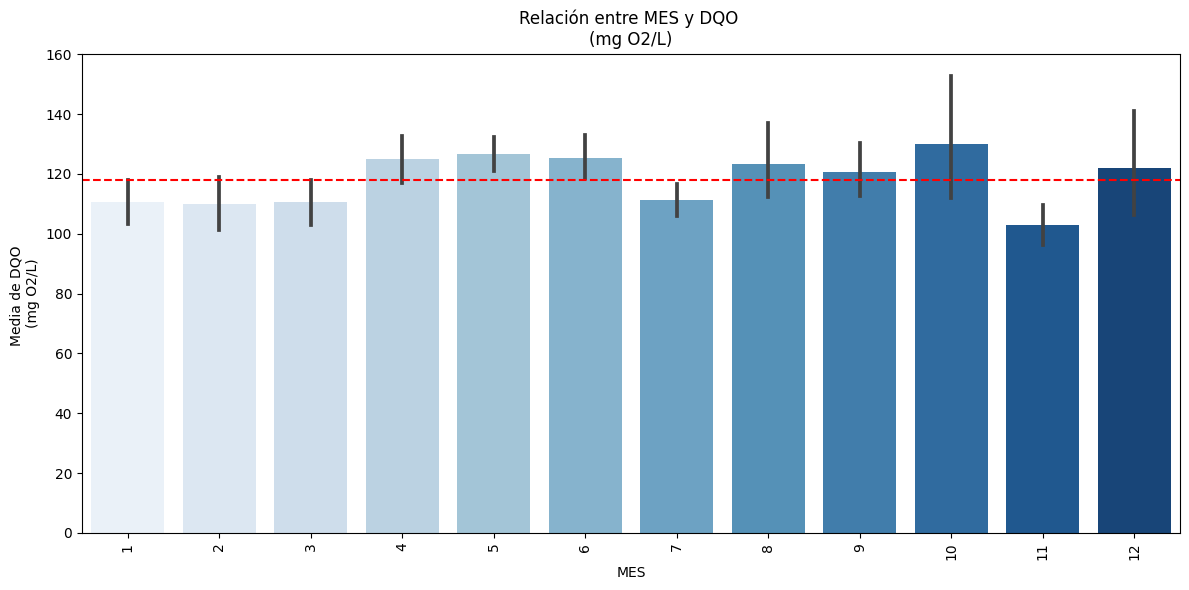

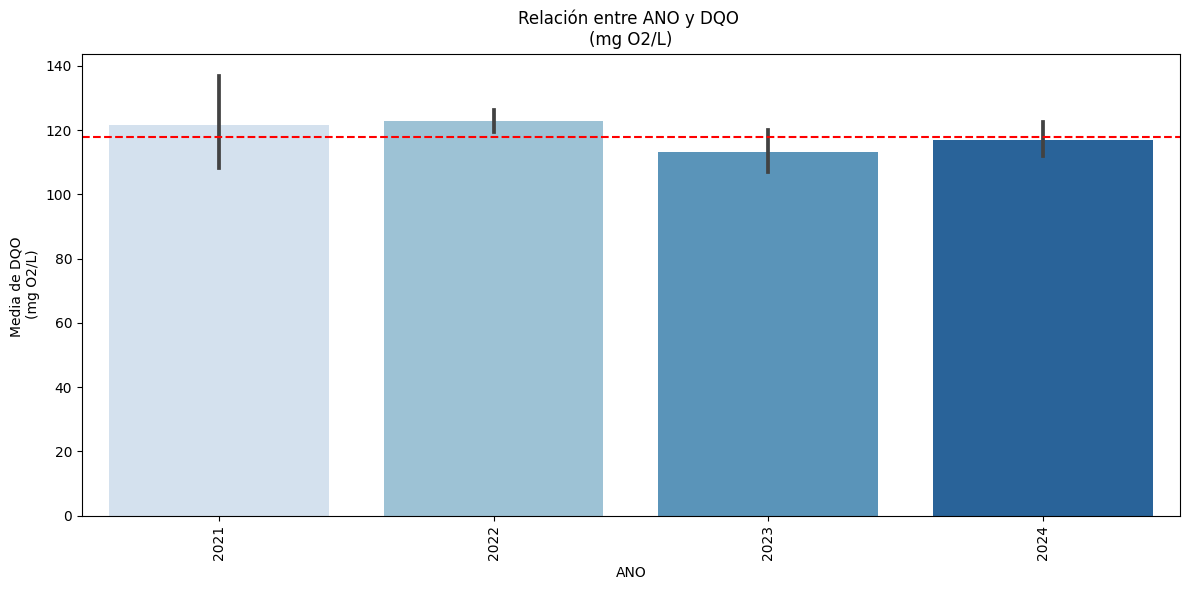

In [192]:
data_lab['DIA'] = data_lab['Fecha'].dt.day
data_lab['MES'] = data_lab['Fecha'].dt.month
data_lab['ANO'] = data_lab['Fecha'].dt.year

plot_categorical_numerical(data_lab, 'DIA', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'MES', 'DQO \n(mg O2/L)')
plot_categorical_numerical(data_lab, 'ANO', 'DQO \n(mg O2/L)')

Mucha consistencia en el tiempo no? o sea no tiene gran seasonality, lo que es bueno creo para una time series prediction

## Correlaciones entre variables

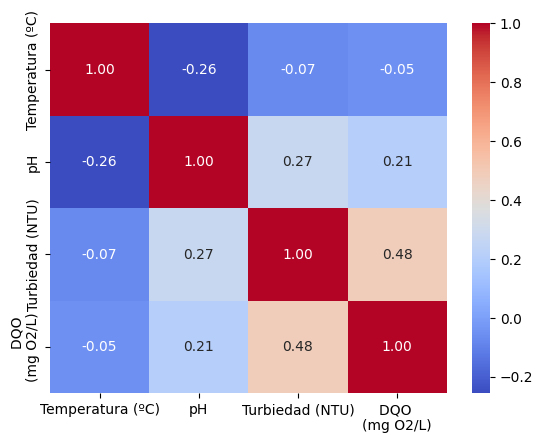

In [189]:
corr_matrix = data_lab.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()